In [1]:
"""
Program Description:
This program reads in a csv file created by the "QCMD_flow_raw_to_adj" program. 
It creates "bricks" of data for easy comparison of different experimental "blocks."

Author:
- Heike Böhm, Department of Cellular Biophysics, MPI for Medical Research (MPImF-CBP-GS)
- With strong support from Martin Schröter in the same department.
- Idea and design for brick structure to enable comparision of different data sets by Florian Köhldorfer, MPImF-CBP-GS.

Input Data Sources:
- CSV File generated by the "QCMD_flow_raw_to_adj" program.

Output Generated:
- New CSV file with the following components:

  - adj_timeline_bricks with 'Change_time', 'Solution', 'Speed', 'Dynamic_brick', 'Brick'
    - The first time point of the experiment is labeled with "PBS," 
      and the end of the experiment is marked as "end of experiment."
    - Dynamic brick is a boolean indicating if the 'Brick' is saved over the full data (dynamic brick) or just 5 min
    
  - adj_qcmd_pd: two new columns added: 'Brick' and 'Rel_brick_time_s' in which the brick number and respective 
    rel. brick time is added, when the data points are part of one of the bricks
      
  - adj_qcmd_bricks_pd based on adj_qcmd_pd, 
    but only contains data belonging to one of the bricks. 
    It contains the columns: Time_s; Overtone; Deltaf_div_n_Hz; Dissipation_ppm; Brick; Rel_brick_time_s
        - Bricks are defined as the data starting 6:00 min before solutions are exchanged 
          until 1:00 min before the exchange.
        - for dynamic bricks, the full brick is added
    
  - mean_brick_np with 'Overtone', 'Brick', 'Mean_value'
      where mean values are averaged over the data starting 6:00 min before solutions are exchanged 
          until 1:00 min before the exchange (full brick for non-dynamic bricks)
      
          
Comments on Coding:
- For all variables, lower_case_with_underscores are used.
- CapWords are used for class names (if applicable).
- UPPER_CASE_WITH_UNDERSCORES are used for constants.
"""


import os
import h5py
import ipywidgets as widgets
import seaborn as sns
import numpy as np
import ast
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time


In [2]:
'''
Enter the path to the folder in which the QCMD flow rawdata is saved
'''

input_widget_width = '1000px'
description_width = '300px'

path_widget = widgets.Text(
    value="Inbox",
    description="Path to QCMD flow rawdata:"
)

path = None

path_widget.layout.width = input_widget_width
path_widget.style.description_width = description_width

def save_path(sender):
    global path 
    path = path_widget.value

save_button = widgets.Button(description="Save")
save_button.on_click(save_path)

widgets.VBox([path_widget, save_button])


In [3]:
def process_adj_qcmd_data(csv_file_path):
    # Extract persistentID from the file name
    persistentID = os.path.basename(csv_file_path)
    persistentID = persistentID.replace("Data_", "").replace("_adj_qcmd_data.csv", "")

    # Read adj_qcmd_data from CSV file
    adj_qcmd_pd = pd.read_csv(csv_file_path, index_col=0)

    # Extract subset of data for the 7th overtone
    adj_qcmd_n7_pd = adj_qcmd_pd[adj_qcmd_pd["Overtone"] == 7]

    # Read timeline data
    timeline_file_path = os.path.join(path, f"Data_{persistentID}_adj_timeline.csv")
    adj_timeline_pd = pd.read_csv(timeline_file_path, index_col=0)

    return persistentID, adj_qcmd_pd, adj_qcmd_n7_pd, adj_timeline_pd


In [4]:
'''
Show complete experiment with all overtones to choose dynamic blocks in next step
'''

def plot_complete_experiment(adj_qcmd_pd, adj_timeline_pd):
    sns.lineplot(data=adj_qcmd_pd, hue="Overtone", x="Time_s", y="Deltaf_div_n_Hz")
    plt.ylim((min(adj_qcmd_pd['Deltaf_div_n_Hz']) - 10), 10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Iterate over the time points and plot vertical dashed lines
    for time_seconds in adj_timeline_pd.iloc[:, 0].tolist():
        plt.axvline(x=time_seconds, color='grey', linestyle='--', label='Time Point')

    plt.title('Complete Experiment')
    plt.tight_layout()

    plt.show()

In [5]:
'''
Input:
- adj_timeline_pd
- adj_qcmd_pd

Output:
- timeline_bricks_pd with times ("Change_times") at which the solutions ("Solution") were exchanged and brick number ("Brick")
    - a line to the end and beginning of the experiment is automatically added
  
Note on Coding:
- we are assuming that the first data is always taken in PBS.
'''

def generate_timeline_bricks(adj_timeline_pd, adj_qcmd_n7_pd):
    # Create a copy of adj_timeline_pd
    timeline_bricks_pd = pd.DataFrame(adj_timeline_pd)
    timeline_bricks_pd.rename(columns={
        'Time': 'Change_time',
        'Information': 'Solution'
    }, inplace=True)
    timeline_bricks_pd['Change_time'] = timeline_bricks_pd['Change_time'].astype(float)
    timeline_bricks_pd['Solution'] = timeline_bricks_pd['Solution'].str.replace("changed to ", "")
    timeline_bricks_pd['Dynamic_brick'] = False

    # Add a line to the end and beginning of the experiment
    new_row = pd.DataFrame(
        {'Change_time': [adj_qcmd_n7_pd["Time_s"].iloc[-2]], 'Solution': ["end of experiment"],
         'Speed': [timeline_bricks_pd['Speed'].iloc[-1]], 'Dynamic_brick': False
        })
    timeline_bricks_pd = pd.concat([timeline_bricks_pd, new_row], ignore_index=True)
    new_row = pd.DataFrame(
        {'Change_time': [adj_qcmd_n7_pd["Time_s"].iloc[0]], 'Solution': ["PBS"],
         'Speed': [timeline_bricks_pd['Speed'].iloc[1]],
         'Dynamic_brick': False
        })
    timeline_bricks_pd = pd.concat([new_row, timeline_bricks_pd], ignore_index=True)

    timeline_bricks_pd['Brick'] = range(1, len(timeline_bricks_pd) + 1)

    return timeline_bricks_pd


In [6]:
def select_dynamic_bricks(timeline_bricks_pd):
    # Declare selected_bricks as a global variable
    global selected_bricks

    # Initialize click_flag
    click_flag = False

    print("Select dynamic bricks by entering brick numbers separated by commas.")
    print("For example: 1, 3, 5")

    # Function to apply the selection
    def apply_selection():
        global selected_bricks
        selected_brick_str = input("Enter dynamic brick numbers: ")
        selected_bricks = [int(brick.strip()) for brick in selected_brick_str.split(',')]

        timeline_bricks_pd['Dynamic_brick'] = False
        timeline_bricks_pd.loc[timeline_bricks_pd['Brick'].isin(selected_bricks), 'Dynamic_brick'] = True
        #display(timeline_bricks_pd)
        nonlocal click_flag
        click_flag = True

    apply_selection()

    return click_flag, selected_bricks


In [7]:
def plot_and_save_complete_experiment(adj_qcmd_n7_pd, timeline_bricks_pd, persistentID, path):
    min_value_f = adj_qcmd_n7_pd[adj_qcmd_n7_pd["Overtone"] == 7]["Deltaf_div_n_Hz"].min() - 10

    sns.set_palette("colorblind")
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Plot on the first y-axis
    line_color1 = sns.color_palette()[0]
    sns.lineplot(data=adj_qcmd_n7_pd, color=line_color1, x="Time_s", y="Deltaf_div_n_Hz", ax=ax1, legend=False)

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Plot on the second y-axis
    line_color2 = sns.color_palette()[1]  # Choose a different color for the second line
    sns.lineplot(data=adj_qcmd_n7_pd, color=line_color2, x="Time_s", y="Dissipation_ppm", ax=ax2, legend=False)

    # Adjust labels and legends as needed
    ax1.set_ylabel('Δf(7)/n [Hz]', color=line_color1)
    ax2.set_ylabel('Dissipation(7) [ppm]', color=line_color2)
    ax1.set_xlabel('time [s]')

    line_color = sns.color_palette()[7]
    for z in timeline_bricks_pd["Change_time"]:
        plt.axvline(x=z, color=line_color, linestyle='--', label='Max Value Time')

    ax1.set_ylim(min_value_f, 9) 
    ax1.set_xlim(0, adj_qcmd_n7_pd["Time_s"].max())

    plt.suptitle(persistentID, fontsize=12)

    y_limits = ax2.get_ylim()

    # Add section numbers above the plot below the title
    
    for i, z in enumerate(timeline_bricks_pd["Change_time"], start=1):
        if i < len(timeline_bricks_pd["Change_time"]):
            center = (z + timeline_bricks_pd["Change_time"].iloc[i]) / 2
            text_y = y_limits[1] - 0  # Adjust the constant value based on your preference
            plt.text(center, text_y, f'{i}', rotation=0, verticalalignment='bottom', horizontalalignment='center', fontsize=8, color=line_color)
    
    table_data = []
    for i, brick in enumerate(timeline_bricks_pd["Brick"][:-1]):
        solution = timeline_bricks_pd["Solution"].iloc[i]
        table_data.append([brick, solution])

    table_header = ["Section", "Solution"]

    col_widths = [0.1, 0.1, 0.2]  # Adjust these values as needed
    table_bbox = [1.1, 0.2, 0.4, 0.6]  # Adjust the values as needed

    header_fontweight = 'bold'

    table = plt.table(cellText=table_data, colLabels=table_header, cellLoc='center', loc='right', edges='open', colWidths=col_widths, bbox=table_bbox)
    for (i, j), cell in table.get_celld().items():
        if i == 0:
            cell.set_text_props(fontweight=header_fontweight)

    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.4, 1.2)  # Adjust the scaling as needed       

    image_name1 = path + "Plot_" + persistentID + "_n7.pdf"
    plt.savefig(image_name1, format='pdf', dpi=300, bbox_inches='tight')
    
    plt.show()

In [8]:
'''
Input:
- timeline_bricks_pd

Output:
- adj_qcmd_pd gets additional columns labeling its relation to a certain brick No, and its rel. time
    - Bricks are defined as the data starting 6:00min before solutions are exchanged until 1:00 min before the exchange.
- adj_qcmd_bricks_pd contains only the data inside any brick from adj_qcmd_data

Note on Coding:
- if brick definition is changed, adapt comment at the start of the program

'''

def process_adj_qcmd_bricks(timeline_bricks_pd, dynamic_bricks, adj_qcmd_pd):
    adj_qcmd_pd['Brick'] = None
    adj_qcmd_pd["Rel_brick_time_s"] = None

    for brick in timeline_bricks_pd['Brick']:
        if brick in dynamic_bricks:
            print(f"{brick} - It's a dynamic brick!")
            brick_start_time = timeline_bricks_pd["Change_time"].iloc[brick - 1] 
            brick_end_time = timeline_bricks_pd["Change_time"].iloc[brick] 
        elif brick == timeline_bricks_pd['Brick'].iloc[-1]:
            print("All bricks have been added")
        else:
            print(brick)
            brick_start_time = timeline_bricks_pd["Change_time"].iloc[brick] - 360
            brick_end_time = timeline_bricks_pd["Change_time"].iloc[brick] - 60

        offset = None

        if brick != timeline_bricks_pd['Brick'].iloc[-1]:
            for index, row in adj_qcmd_pd.iterrows():
                if brick_start_time <= row['Time_s'] <= brick_end_time:
                    adj_qcmd_pd.at[index, 'Brick'] = brick
                    if offset is None:
                        offset = row['Time_s']

            for index, row in adj_qcmd_pd.iterrows():
                if brick_start_time <= row['Time_s'] <= brick_end_time:
                    adj_qcmd_pd.at[index, 'Rel_brick_time_s'] = row['Time_s'] - offset

    adj_qcmd_bricks_pd = adj_qcmd_pd[adj_qcmd_pd['Brick'].notna()]

    return adj_qcmd_pd, adj_qcmd_bricks_pd

In [9]:
def mean_value_calc(adj_qcmd_bricks_pd, timeline_bricks_pd):
    unique_bricks = adj_qcmd_bricks_pd['Brick'].unique()
    unique_overtones = adj_qcmd_bricks_pd['Overtone'].unique()
    mean_brick_values = []
    
    for overtone in unique_overtones:
        for brick in unique_bricks:
            # Check if the brick is dynamic
            is_dynamic = timeline_bricks_pd.loc[timeline_bricks_pd['Brick'] == brick, 'Dynamic_brick'].iloc[0] if brick in timeline_bricks_pd['Brick'].values else False
            
            data_within_timeframe = adj_qcmd_bricks_pd[
                (adj_qcmd_bricks_pd['Brick'] == brick) &
                (adj_qcmd_bricks_pd['Overtone'] == overtone)
            ]
            
            # Check if the brick is empty (no data)
            if len(data_within_timeframe) == 0:
                # Set mean to None or NaN to indicate empty brick
                mean = None  # or mean = np.nan
                mean_brick_values.append((overtone, brick, mean))
                continue
                
            # Calculate the mean while ignoring nan values
            if is_dynamic:
                last_time = data_within_timeframe['Rel_brick_time_s'].max()
                start_time = last_time - 6 * 60  
                end_time = last_time - 60
                plateau_pd = data_within_timeframe[
                    (data_within_timeframe['Rel_brick_time_s'] >= start_time) &
                    (data_within_timeframe['Rel_brick_time_s'] <= end_time)
                ]
                
                # Check if plateau data is empty
                if len(plateau_pd) == 0:
                    mean = None  # or mean = np.nan
                else:
                    mean = np.nanmean(plateau_pd['Deltaf_div_n_Hz'])
            else:
                # If not dynamic brick, calculate the mean as before
                mean = np.nanmean(data_within_timeframe['Deltaf_div_n_Hz'])
                
            mean_brick_values.append((overtone, brick, mean))
            
    mean_brick_pd = pd.DataFrame(mean_brick_values, columns=['Overtone', 'Brick', 'Mean'])
    # Keep None values as None, but convert numeric values to float
    mean_brick_pd['Mean'] = mean_brick_pd['Mean'].apply(lambda x: float(x) if x is not None else None)
    
    return mean_brick_pd

In [10]:
def plot_bricks(timeline_bricks_pd, adj_qcmd_bricks_pd, mean_brick_pd, dynamic_brick, persistentID):
    sns.set_palette("colorblind")

    # Define the number of "Brick" entries automatically
    num_bricks = len(timeline_bricks_pd['Brick'])-1

    fig, axes = plt.subplots(2, num_bricks, figsize=(16, 8), gridspec_kw={'height_ratios': [2, 1]})

    line_color1 = sns.color_palette()[0]
    line_color2 = sns.color_palette()[4]
    line_color3 = sns.color_palette()[1]
    line_color4 = sns.color_palette()[3]

    min_value_f = adj_qcmd_bricks_pd["Deltaf_div_n_Hz"].min() - 10
    max_value_D = adj_qcmd_bricks_pd["Dissipation_ppm"].max() + 1
    min_value_D = adj_qcmd_bricks_pd["Dissipation_ppm"].min() - 1

    for i in range(1, num_bricks+1):
        data = adj_qcmd_bricks_pd[(adj_qcmd_bricks_pd["Brick"] == i) & (adj_qcmd_bricks_pd["Overtone"] == 7)]
        data2 = adj_qcmd_bricks_pd[(adj_qcmd_bricks_pd["Brick"] == i)]
        
        ax = axes[0, i-1]
        
        # Check if brick contains data
        brick_is_empty = len(data) == 0 or len(data2) == 0
        
        # Get mean value if available
        mean_value_series = mean_brick_pd[(mean_brick_pd['Brick'] == i) & (mean_brick_pd['Overtone'] == 7)]['Mean']
        
        if not brick_is_empty and not mean_value_series.empty and mean_value_series.iloc[0] is not None:
            mean_value = mean_value_series.iloc[0]
            y_position = mean_value + 1
            
            # Only display text if there's data
            if len(data) > 0:
                x_position = data['Rel_brick_time_s'].iloc[-1]
                ax.text(x_position, y_position, f"{mean_value:.2f}", fontsize=12, ha='right')
        
        if not brick_is_empty:
            if i in dynamic_brick:
                sns.lineplot(
                    data=data2, x="Rel_brick_time_s", y="Deltaf_div_n_Hz", 
                    ax=ax, hue="Overtone", legend=False, alpha=0.4
                )
                if len(data) > 0:
                    sns.lineplot(data=data, color=line_color2, x="Rel_brick_time_s", y="Deltaf_div_n_Hz", ax=ax, alpha=1.0)

                ax.tick_params(axis='x', colors=line_color2)
                for label in ax.get_xticklabels():
                    label.set_weight('bold')
            else:
                sns.lineplot(
                    data=data2, x="Rel_brick_time_s", y="Deltaf_div_n_Hz", 
                    ax=ax, hue="Overtone", legend=False, alpha=0.4
                )
                if len(data) > 0:
                    sns.lineplot(data=data, color=line_color1, x="Rel_brick_time_s", y="Deltaf_div_n_Hz", ax=ax)
        
        ax.set_ylim(min_value_f, 9)
        ax.set_title(f"{str(timeline_bricks_pd['Solution'][i - 1])} ({str(timeline_bricks_pd['Speed'][i - 1])})")

        if i == 1:
            ax.yaxis.set_ticks_position('left')
            ax.set_ylabel('Δf/n [Hz]')
        else:
            ax.set_ylabel("")
            ax.set(yticklabels=[])

        ax.set_xlabel("") 
        ax.yaxis.grid(which='major', color='lightgrey', linestyle='-', linewidth=0.5)

    for i in range(1, num_bricks + 1):
        data = adj_qcmd_bricks_pd[(adj_qcmd_bricks_pd["Brick"] == i) & (adj_qcmd_bricks_pd["Overtone"] == 7)]
        data2 = adj_qcmd_bricks_pd[(adj_qcmd_bricks_pd["Brick"] == i)]

        ax = axes[1, i-1]
        
        # Check if brick contains data
        brick_is_empty = len(data) == 0 or len(data2) == 0
        
        if not brick_is_empty:
            if i in dynamic_brick:   
                sns.lineplot(
                    data=data2, x="Rel_brick_time_s", y="Dissipation_ppm", 
                    ax=ax, hue="Overtone", legend=False, alpha=0.4
                )
                if len(data) > 0:
                    sns.lineplot(data=data, color=line_color3, x="Rel_brick_time_s", y="Dissipation_ppm", ax=ax)
                
                ax.tick_params(axis='x', colors=line_color3)
                for label in ax.get_xticklabels():
                    label.set_weight('bold')
                ax.set_xlabel(f"t_{i} [s]", color=line_color3, fontweight='bold')  
            else:
                sns.lineplot(
                    data=data2, x="Rel_brick_time_s", y="Dissipation_ppm", 
                    ax=ax, hue="Overtone", legend=False, alpha=0.4
                )
                if len(data) > 0:
                    sns.lineplot(data=data, color=line_color4, x="Rel_brick_time_s", y="Dissipation_ppm", ax=ax)
                
                ax.set_xlabel(f"t_{i} [s]")

        ax.set_ylim(min_value_D, max_value_D)

        if i == 1:
            ax.set_ylabel("D/n [ppm]")
        else:
            ax.set_ylabel("")
            ax.set(yticklabels=[])

        ax.yaxis.grid(which='major', color='lightgrey', linestyle='-', linewidth=0.5)

    plt.suptitle(persistentID, fontsize=16)

    description = "Plateau values correspond to the mean value of the 7th overtone for the entire brick or the last 6 to 1 minute of the dynamic brick."
    description2 = "Additional overtone values can be observed in graphs with 40% transparency. Numbers in brick title correspond to µm/min"
    description3 = "Empty bricks indicate no data was available for that measurement."

    plt.text(0.5, -0.01, description, ha='center', va='center', transform=fig.transFigure)
    plt.text(0.5, -0.03, description2, ha='center', va='center', transform=fig.transFigure)
    plt.text(0.5, -0.05, description3, ha='center', va='center', transform=fig.transFigure)

    image_name0 = os.path.join(path, f"Plot_{persistentID}_bricks.pdf")

    plt.savefig(image_name0, format='pdf', dpi=300, bbox_inches='tight')
    
    plt.show()

In [11]:
SAUERBREY_C = 17.7

import numpy as np

def calculate_sauerbrey_mass(adj_qcmd_data_bricks, mean_brick_pd, brick_pairs):
    columns_detailed = ['Brick1', 'Brick2', 'Overtone', 'Mean_f1', 'Mean_f2', 'Mean_D1', 'Mean_D2', 'Delta_f', 'Delta_m']
    columns_summary = ['Brick1', 'Brick2', 'Mean_Delta_M', 'Std_Delta_M', 'Delta_M_Overtone7']
    
    sauerbrey_detailed_df = pd.DataFrame(columns=columns_detailed)
    sauerbrey_summary_df = pd.DataFrame(columns=columns_summary)

    dataframes_to_concat_detailed = []
    dataframes_to_concat_summary = []

    for brick_pair in brick_pairs:
        brick1, brick2 = brick_pair

        delta_m_values = []
        overtones_larger_than_4 = []

        unique_overtones = mean_brick_pd['Overtone'].unique()
        for overtones in unique_overtones:
            freq1_data = mean_brick_pd[(mean_brick_pd["Overtone"] == overtones) & (mean_brick_pd["Brick"] == brick1)]
            freq1 = freq1_data['Mean'].iloc[0]
            freq2_data = mean_brick_pd[(mean_brick_pd["Overtone"] == overtones) & (mean_brick_pd["Brick"] == brick2)]
            freq2 = freq2_data['Mean'].iloc[0]
            delta_f = abs(freq1 - freq2)
            delta_m = SAUERBREY_C * delta_f
            mean_D1 = adj_qcmd_data_bricks.loc[
                (adj_qcmd_data_bricks["Brick"] == brick1) & (adj_qcmd_data_bricks["Overtone"] == overtones), "Dissipation_ppm"
            ].mean()
            mean_D2 = adj_qcmd_data_bricks.loc[
                (adj_qcmd_data_bricks["Brick"] == brick2) & (adj_qcmd_data_bricks["Overtone"] == overtones), "Dissipation_ppm"
            ].mean()

            data_dict_detailed = {
                'Brick1': brick1,
                'Brick2': brick2,
                'Overtone': overtones,
                'Mean_f1': freq1,
                'Mean_f2': freq2,
                'Mean_D1': mean_D1,
                'Mean_D2': mean_D2,
                'Delta_f': delta_f,
                'Delta_m': delta_m,
                'Brick_Pair': f"({brick1}-{brick2})"
            }

            dataframes_to_concat_detailed.append(pd.DataFrame([data_dict_detailed]))

            # Store delta_m values for later calculations
            delta_m_values.append(delta_m)
            overtones_larger_than_4.append(overtones)

        # Calculate mean and standard deviation of delta_m for overtones larger than 4
        delta_m_values = np.array(delta_m_values)
        overtones_larger_than_4 = np.array(overtones_larger_than_4)
        
        mean_delta_m = np.mean(delta_m_values[overtones_larger_than_4 > 4])
        std_delta_m = np.std(delta_m_values[overtones_larger_than_4 > 4])

        # Get delta_m value for overtone 7
        delta_m_overtone7 = delta_m_values[overtones_larger_than_4 == 7][0]

        data_dict_summary = {
            'Brick1': brick1,
            'Brick2': brick2,
            'Mean_Delta_M': mean_delta_m,
            'Std_Delta_M': std_delta_m,
            'Delta_M_Overtone7': delta_m_overtone7,
            'Brick_Pair': f"({brick1}-{brick2})"
        }

        dataframes_to_concat_summary.append(pd.DataFrame([data_dict_summary]))

    # Concatenate the DataFrames in the lists
    sauerbrey_detailed_df = pd.concat(dataframes_to_concat_detailed, ignore_index=True)
    sauerbrey_summary_df = pd.concat(dataframes_to_concat_summary, ignore_index=True)

    return sauerbrey_detailed_df, sauerbrey_summary_df



In [12]:
def select_sauerbrey_bricks(timeline_bricks_pd):
    # Declare selected_bricks as a global variable
    global selected_bricks

    # Initialize click_flag
    click_flag = False

    print("Select Sauerbrey brick pairs for plotting by entering pairs of brick numbers separated by commas.")
    print("To ensure that the Sauerbey relation can be used, the mean Dissipation values (mean_D1 and mean_D2)")
    print("of both bricks should be small and the delta_f of all overtones should be similar.")

    print("For example: 1,5,2,4")
    
    print("Type in 0, if no mass should be calculated")

    # Function to apply the selection
    def apply_selection():
        global selected_bricks
        brick_numbers = input("Enter brick pairs separated by commas: ").split(',')

        # Check if the user entered 0
        if '0' in brick_numbers:
            selected_bricks = []
        else:
            brick_numbers = [int(brick) for brick in brick_numbers]

            # Check if the number of bricks is even
            if len(brick_numbers) % 2 != 0:
                print("Error: Please enter an even number of bricks.")
                return

            # Convert pairs to tuples
            selected_bricks = [(brick_numbers[i], brick_numbers[i + 1]) for i in range(0, len(brick_numbers), 2)]

            print("Selected bricks:", selected_bricks)

        nonlocal click_flag
        click_flag = True


    apply_selection()

    return click_flag, selected_bricks



In [13]:
def plot_and_save_sauerbrey_mass(sauerbrey_detailed_df, sauerbrey_summary_df, persistentID, path):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3.54, 2.36))  # 90 mm width, 60% of the width for a single column

    # Melt the detailed DataFrame to make plotting easier
    sauerbrey_melted = pd.melt(sauerbrey_detailed_df, id_vars=['Overtone', 'Brick_Pair'],
                               value_vars=['Delta_m'], var_name='Measurement', value_name='Delta_Mass')

    ax.set_xticks([0, 3, 5, 7, 9, 11, 13, 15])

    sns.lineplot(data=sauerbrey_melted, x='Overtone', y='Delta_Mass', hue='Brick_Pair', marker='o', markersize=8, ax=ax, palette="colorblind", linestyle='')

    # Add horizontal lines representing the average values from sauerbrey_summary_df
    for index, row in sauerbrey_summary_df.iterrows():
        brick_pair = row['Brick_Pair']
        ax.axhline(y=row['Mean_Delta_M'], linestyle='--', color=sns.color_palette("colorblind")[list(sauerbrey_melted['Brick_Pair'].unique()).index(brick_pair)], linewidth=1, label=f'{brick_pair} Average: {row["Mean_Delta_M"]:.0f} ± {row["Std_Delta_M"]:.0f}')

    ax.set_xlabel('Overtone', fontsize=12)
    ax.set_ylabel('Ads. Mass [ng/cm^2]', fontsize=12)
    ax.set_title(f'Sauerbrey Mass Calculation ({persistentID})', fontsize=12, pad=20)  # Increase pad for more space    
        
    # Create a custom legend
    handles, labels = ax.get_legend_handles_labels()
    brick_pairs_int = [f"{pair}" for pair in labels]
    custom_legend = ax.legend(handles=handles, labels=brick_pairs_int, title='Brick Pair', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Customize grid style
    ax.grid(ls='--', alpha=0.7)
    
    description = "Average values are calculated between all overtones > 3"
    
    plt.text(0.5, -0.15, description, ha='center', va='center', transform=fig.transFigure, fontsize=10)
    
    image_name_sm = os.path.join(path, f"Plot_{persistentID}_sauerbrey.pdf")

    plt.savefig(image_name_sm, format='pdf', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()


Reading in the single sensor data and ensuring that everything is correct
1: Data_CBP_LEAF_5348222_20250530_S3_QCMD_adj_qcmd_data.csv
Opening adj_qcmd_data and adj_timeline for persistent ID:  CBP_LEAF_5348222_20250530_S3_QCMD
Calculating the bricks from the complete data set


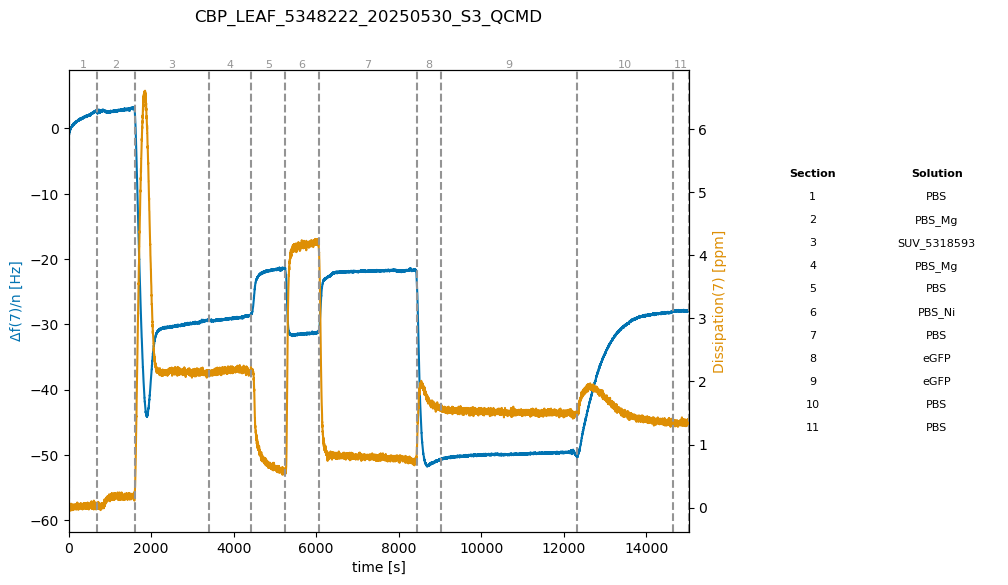

Select dynamic bricks by entering brick numbers separated by commas.
For example: 1, 3, 5


Enter dynamic brick numbers:  3,8,10


1
2
3 - It's a dynamic brick!
4
5
6
7
8 - It's a dynamic brick!
9
10 - It's a dynamic brick!
11
All bricks have been added


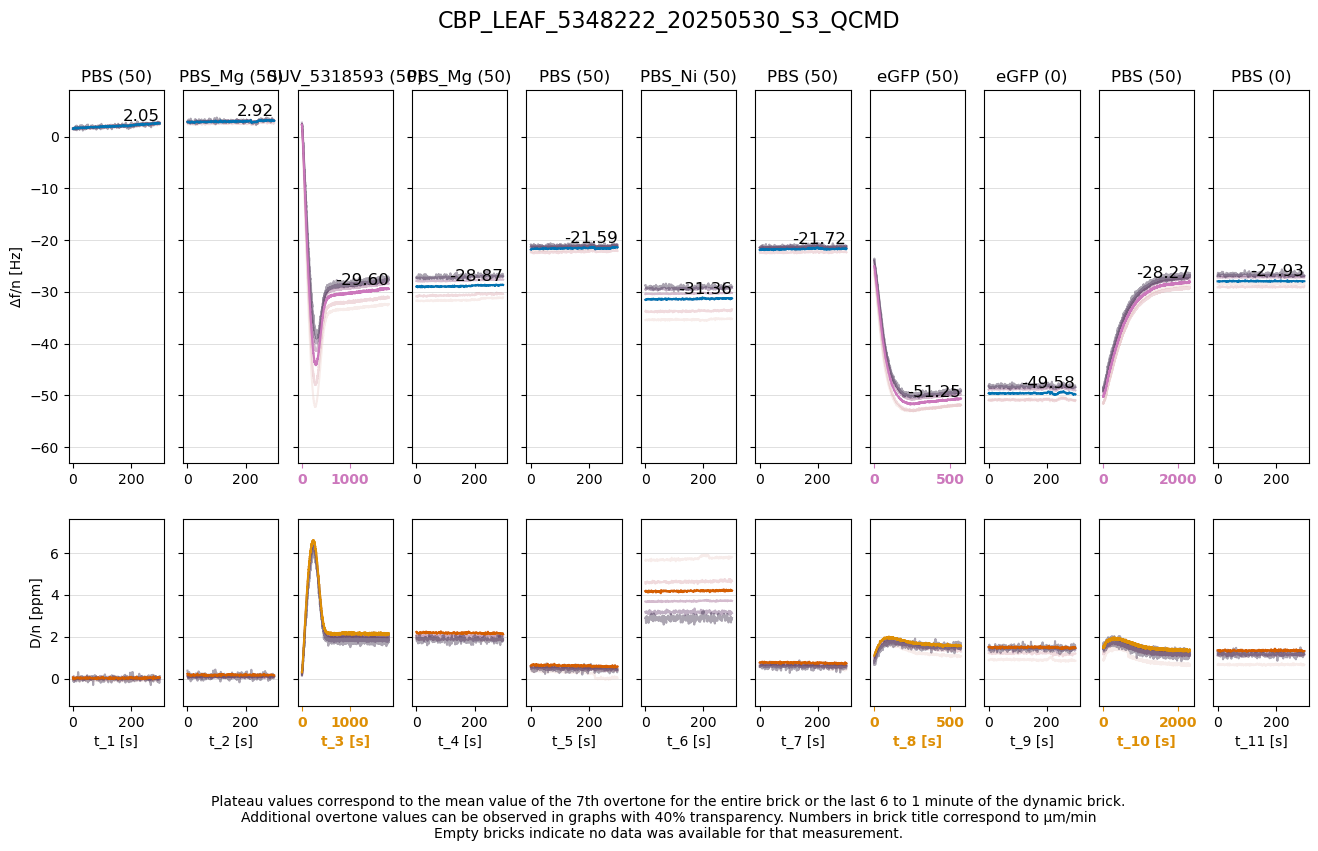

Select Sauerbrey brick pairs for plotting by entering pairs of brick numbers separated by commas.
To ensure that the Sauerbey relation can be used, the mean Dissipation values (mean_D1 and mean_D2)
of both bricks should be small and the delta_f of all overtones should be similar.
For example: 1,5,2,4
Type in 0, if no mass should be calculated


Enter brick pairs separated by commas:  1,5,5,7,7,11


Selected bricks: [(1, 5), (5, 7), (7, 11)]


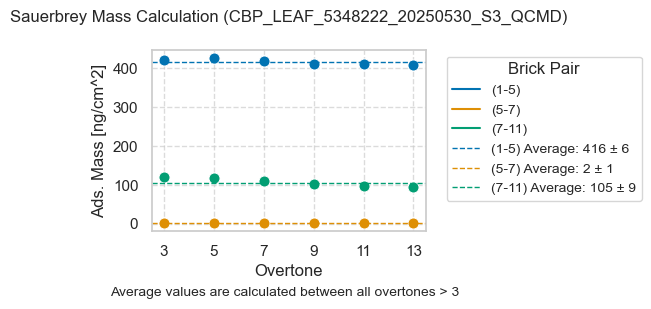

In [14]:
def identify_similar_files(directory):
    files = os.listdir(directory)
    similar_files = [file for file in files if "adj_qcmd_data.csv" in file.lower()]
    return similar_files

click_flag = False

def main():
    adj_qcmd_data_files = identify_similar_files(path)
    if not adj_qcmd_data_files:
        print(f"There are no files containing 'adj_qcmd_data.csv' in the folder {path}")
        return
    
    print("Reading in the single sensor data and ensuring that everything is correct")
    
    for i, file in enumerate(adj_qcmd_data_files, start=1):
        print(f"{i}: {file}")
        file_path = os.path.join(path, file)
        
        persistentID, adj_qcmd_pd, adj_qcmd_n7_pd, adj_timeline_pd = process_adj_qcmd_data(file_path)
        print("Opening adj_qcmd_data and adj_timeline for persistent ID: ", persistentID)
        
        # Generate timeline bricks
        timeline_bricks_pd = generate_timeline_bricks(adj_timeline_pd, adj_qcmd_n7_pd)
        
        print("Calculating the bricks from the complete data set")
        # Plot and save complete experiment
        plot_and_save_complete_experiment(adj_qcmd_n7_pd, timeline_bricks_pd, persistentID, path)
        
        # Call the function to select dynamic bricks
        click_flag, selected_bricks = select_dynamic_bricks(timeline_bricks_pd)
        # Process adj_qcmd_bricks
        adj_qcmd_pd, adj_qcmd_bricks_pd = process_adj_qcmd_bricks(timeline_bricks_pd, selected_bricks, adj_qcmd_pd)
        
        mean_brick_pd = mean_value_calc(adj_qcmd_bricks_pd, timeline_bricks_pd)
        
        plot_bricks(timeline_bricks_pd, adj_qcmd_bricks_pd, mean_brick_pd, selected_bricks, persistentID)
        
        # Select Sauerbrey bricks
        click_flag, selected_sauerbrey_bricks = select_sauerbrey_bricks(timeline_bricks_pd)
        
        # Check if the user opted not to calculate Sauerbrey mass
        if not selected_sauerbrey_bricks:
            print("Sauerbrey mass calculation skipped.")
        else:
            # Calculate and plot Sauerbrey mass
            sauerbrey_detailed_df, sauerbrey_summary_df = calculate_sauerbrey_mass(adj_qcmd_bricks_pd, mean_brick_pd, selected_sauerbrey_bricks)
            plot_and_save_sauerbrey_mass(sauerbrey_detailed_df, sauerbrey_summary_df, persistentID, path)
            # Fixed file path construction
            csv_file_name5 = os.path.join(path, f"Data_{persistentID}_sauerbrey_mass.csv")
            sauerbrey_detailed_df.to_csv(csv_file_name5, index=True)
            csv_file_name6 = os.path.join(path, f"Data_{persistentID}_sauerbrey_average.csv")
            sauerbrey_summary_df.to_csv(csv_file_name6, index=True)
        
        # Fixed file path construction for all CSV files
        csv_file_name1 = os.path.join(path, f"Data_{persistentID}_adj_qcmd_data.csv")
        adj_qcmd_pd.to_csv(csv_file_name1, index=True)
        csv_file_name2 = os.path.join(path, f"Data_{persistentID}_adj_qcmd_bricks_data.csv")
        adj_qcmd_bricks_pd.to_csv(csv_file_name2, index=True)
        csv_file_name3 = os.path.join(path, f"Data_{persistentID}_adj_timeline_bricks.csv")
        timeline_bricks_pd.to_csv(csv_file_name3, index=True)
        csv_file_name4 = os.path.join(path, f"Data_{persistentID}_mean_brick_values.csv")
        mean_brick_pd.to_csv(csv_file_name4, index=True)
        
        # Reset global variables
        selected_bricks = None
        click_flag = False
        
if __name__ == "__main__":
    main()